In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier, plot_importance

In [3]:
import waterfall_chart

In [4]:
import seaborn as sns
sns.set_style("white")

In [5]:
%matplotlib inline

# Dane

In [6]:
DATA_PATH = "Datasets/HCMST 2017 fresh sample for public sharing draft v1.1.dta"

In [7]:
df = pd.read_stata(DATA_PATH)

In [8]:
target = ["S1"]
cat_feat = ['hcm2017q24_school', 'PPT612']
float_feat = ['w6_q21a_year', 'weight_combo_v2']
feat = cat_feat + float_feat + target

In [9]:
df = df[feat]
df = df.dropna()
df[cat_feat] = df[cat_feat].apply(lambda x: x.cat.codes, axis=0)
df[target] = (df[target] == "Yes, I am Married").astype(int)

In [10]:
df_X = df[feat[:-1]]
df_y = df[target]

# Model

In [11]:
X = df_X.values
y = df_y.values

In [12]:
fix_params = {'objective': 'binary:logistic', "seed": 42}
param_dist = {
    'n_estimators': stats.randint(150, 500),
    'learning_rate': np.linspace(0.01,0.1, 10),
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)],
    'max_depth': [3, 4, 5, 6, 7, 8, 9],
    'colsample_bytree': stats.uniform(0.5, 0.45),
    'min_child_weight':[1, 2, 4, 6, 8, 10, 12],
    'gamma':[i/10.0 for i in range(0,5)]
             }
clf = RandomizedSearchCV(estimator=XGBClassifier(**fix_params), param_distributions = param_dist, n_iter = 25, scoring = 'f1', cv=5, n_jobs = -1)
clf.fit(X,y)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=1),
          fit_params=None, iid='warn', n_iter=25, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd5410cc550>, 'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ]), 'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd5410ccf28>, 'max_depth': [3, 4, 5, 6, 7, 8, 9], 'min_child_weight': [1, 2, 4, 6, 8, 10, 12], 'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
          pre_dispatch='

In [13]:
best_params = {**clf.best_params_, **fix_params}
clf_xgb = XGBClassifier(**best_params)
clf_xgb.fit(X,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8088646613567898, gamma=0.0, learning_rate=0.01,
       max_delta_step=0, max_depth=6, min_child_weight=12, missing=None,
       n_estimators=259, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.6)

# Zmiana w średniej odpowiedzi modelu

In [14]:
def mean_per_respon(df, model, attrs, values):
    df = df.copy()
    means = []
    attrs = np.array(attrs)
    per = np.random.permutation(4)
    means.append(model.predict_proba(df.values)[:,1].mean())
    for i in range(4):
        df[attrs[per][i]] = values[per][i]
        means.append(model.predict_proba(df.values)[:,1].mean())
        
    df_means = pd.DataFrame(data={"means":means}, index = ['intercept'] + list(attrs[per]))
    df_means['means'] = df_means['means'].diff().fillna(df_means['means'])
    waterfall_chart.plot(index=df_means.index, data=df_means["means"], rotation_value=90, formatting='{:,.3f}', Title="Zmiany w średnich")

In [15]:
obs = 480

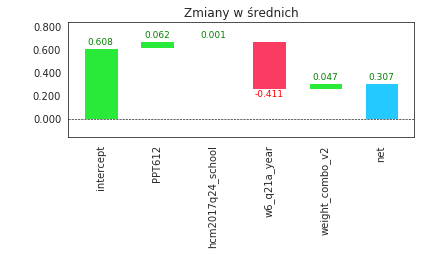

In [16]:
mean_per_respon(df_X, clf_xgb, feat[:-1], X[obs])

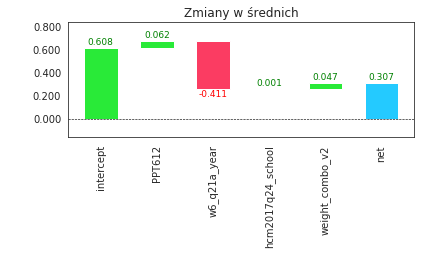

In [17]:
mean_per_respon(df_X, clf_xgb, feat[:-1], X[obs])

# Wnioski:
Próbowałem paru roznych obserwacji z paroma roznymi losowymi ustawieniami zmiennych, lecz efekt utrzymywał sie w podobnym zakresie. Byc moze jest to spowodowane tym, że od poczatku wybralem cechy nieskorelowane ze sobą, oraz użyłem grid searcha do przeszukania modelu dającego dobre wyniki.